In [1]:
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from src.data_loader import load_full_data, load_filtered_data, get_dataloader
from src.features import get_features_and_target, get_onehot_midi_sequences, apply_polynomial_expansion, apply_rbf_kernel_approximation
from src.models import train_linear, train_ridge, train_lasso, OneHotMLP, simple_train_fn, PolyMLP, DeepMLP
from src.utils import split_data
from src.evaluation import evaluate_model, print_coefficients, cross_validate_model, bootstrap_prediction_intervals, kfold_bootstrap_ci_analysis, evaluate_NN_model

random.seed(1)

## Linear Regression (authentic cadence, notes only)

In [2]:
# --- Load truncated stems of authentic cadence ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath, prefix="HC")
X, y = get_features_and_target(df, feature_steps=range(1,7), target_col='step7')

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train model ---
model = train_linear(x_train, y_train)

# --- Evaluate model ---
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)

# --- Print coefficients ---
print_coefficients(model, X)

# --- 5-fold cross-validation ---
cross_validate_model(X, y, k=5)

ci_df = kfold_bootstrap_ci_analysis(
    model_type="linear",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 7.9111
Training set r-squared score: 0.2862
Validation set mean squared error: 3.3977
Validation set r-squared score: -11.6748
Testing set mean squared error: 12.6978
Testing set r-squared score: -7.5178

Learned coefficients (weights for each feature):
Feature 1: -0.0223
Feature 2: 0.0030
Feature 3: -0.0415
Feature 4: -0.5084
Feature 5: 0.0757
Feature 6: 0.3241

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 20.7250, R² = -1.3075
Fold 2: MSE = 27.5917, R² = -0.7690
Fold 3: MSE = 12.5057, R² = -0.6966
Fold 4: MSE = 16.2414, R² = -0.7736
Fold 5: MSE = 13.8226, R² = -3.7817

***** Average over 5 folds *****
Average MSE: 18.1773
Average R²: -1.4657

Overall coverage across all folds: 44.44% within 95% CI


## Linear Regression (authentic cadence, notes and key)

In [3]:
from src.data_loader import load_filtered_data
from src.features import get_features_and_target
from src.models import train_linear
from src.utils import split_data
from src.evaluation import evaluate_model, print_coefficients, cross_validate_model, kfold_bootstrap_ci_analysis

# --- Load and preprocess ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath, prefix="HC")

# Add numeric features for key and dominant chord
KEY_TO_MIDI = {
    'C': 60, 'C_sharp': 61, 'D_flat': 61, 'D': 62, 'E_flat': 63, 'E': 64,
    'F': 65, 'F_sharp': 66, 'G': 67, 'A_flat': 68, 'A': 69, 'B_flat': 70, 'B': 71
}
df['key_midi'] = df['key'].map(KEY_TO_MIDI)

# --- Feature extraction ---
X, y = get_features_and_target(
    df,
    feature_steps=range(1, 7),
    extra_feature_cols=['key_midi'],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_linear(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model, X)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="linear",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 7.3684
Training set r-squared score: 0.1528
Validation set mean squared error: 12.1060
Validation set r-squared score: -2.8608
Testing set mean squared error: 6.5639
Testing set r-squared score: 0.0709

Learned coefficients (weights for each feature):
Feature 1: 0.0147
Feature 2: -0.0137
Feature 3: 0.0435
Feature 4: -0.3289
Feature 5: 0.0343
Feature 6: 0.1817
Feature 7: -0.0308

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 16.7807, R² = -0.8683
Fold 2: MSE = 26.5663, R² = -0.7033
Fold 3: MSE = 11.5641, R² = -0.5689
Fold 4: MSE = 15.7292, R² = -0.7176
Fold 5: MSE = 8.1048, R² = -1.8037

***** Average over 5 folds *****
Average MSE: 15.7490
Average R²: -0.9324

Overall coverage across all folds: 55.56% within 95% CI


## Linear Regression (authentic cadence, notes and key and V chord)

In [4]:
# --- Load and preprocess ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath, prefix="HC")

# Add numeric features for key and dominant chord
KEY_TO_MIDI = {
    'C': 60, 'C_sharp': 61, 'D_flat': 61, 'D': 62, 'E_flat': 63, 'E': 64,
    'F': 65, 'F_sharp': 66, 'G': 67, 'A_flat': 68, 'A': 69, 'B_flat': 70, 'B': 71
}
df['key_midi'] = df['key'].map(KEY_TO_MIDI)
df['V_midi'] = df['V_chord_root']

# --- Feature extraction ---
X, y = get_features_and_target(
    df,
    feature_steps=range(1, 7),
    extra_feature_cols=['key_midi', 'V_midi'],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_linear(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model, X)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="linear",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 7.3690
Training set r-squared score: 0.1964
Validation set mean squared error: 14.9451
Validation set r-squared score: -0.1683
Testing set mean squared error: 7.9066
Testing set r-squared score: -0.0698

Learned coefficients (weights for each feature):
Feature 1: 0.0360
Feature 2: 0.0183
Feature 3: -0.1010
Feature 4: -0.2458
Feature 5: 0.0671
Feature 6: 0.2235
Feature 7: -0.1939
Feature 8: -0.1678

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 10.0654, R² = -0.1207
Fold 2: MSE = 20.0115, R² = -0.2830
Fold 3: MSE = 8.2748, R² = -0.1226
Fold 4: MSE = 17.5877, R² = -0.9206
Fold 5: MSE = 7.9229, R² = -1.7408

***** Average over 5 folds *****
Average MSE: 12.7725
Average R²: -0.6375

Overall coverage across all folds: 62.22% within 95% CI


# Linear Regression (authentic cadences, notes + contour features)

In [5]:
# --- Intervals & Contour ---
for i in range(1, 6):
    df[f'intv{i}'] = df[f'step{i+1}'] - df[f'step{i}']
    df[f'is_rising{i}'] = (df[f'step{i+1}'] > df[f'step{i}']).astype(int)

# --- Tonal Distance ---
df['step6_to_key'] = (df['step6'] - df['key_midi']) % 12
df['step6_to_V'] = (df['step6'] - df['V_midi']) % 12

# --- Pitch Classes ---
for i in range(1, 7):
    df[f'step{i}_pc'] = df[f'step{i}'] % 12

X, y = get_features_and_target(
    df,
    feature_steps=[],  
    extra_feature_cols=[
        'intv1', 'intv2', 'intv3', 'intv4', 'intv5',
        'is_rising1', 'is_rising2', 'is_rising3', 'is_rising4', 'is_rising5',
        'step6_to_key', 'step6_to_V',
        'key_midi', 'V_midi'
    ],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_linear(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model, X)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="linear",
    X=X,
    y=y,
    k=5,
    n_bootstraps=10000,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 5.1920
Training set r-squared score: 0.4387
Validation set mean squared error: 11.2881
Validation set r-squared score: -0.1267
Testing set mean squared error: 6.1033
Testing set r-squared score: -2.6214

Learned coefficients (weights for each feature):
Feature 1: 0.0988
Feature 2: -0.1236
Feature 3: 0.2002
Feature 4: -0.0026
Feature 5: 0.0455
Feature 6: -1.9851
Feature 7: 3.1228
Feature 8: -1.4655
Feature 9: 4.8218
Feature 10: 1.3752
Feature 11: -0.3343
Feature 12: -0.4854
Feature 13: -0.3638
Feature 14: -0.1628

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 4.0544, R² = 0.5486
Fold 2: MSE = 21.3119, R² = -0.3664
Fold 3: MSE = 10.0053, R² = -0.3574
Fold 4: MSE = 23.4094, R² = -1.5563
Fold 5: MSE = 18.7252, R² = -5.4776

***** Average over 5 folds *****
Average MSE: 15.5012
Average R²: -1.4418

Overall coverage across all folds: 86.67% within 95% CI


## Ridge Regression (authentic cadence, notes only)

In [6]:
# --- Load truncated stems of authentic cadence ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath)
X, y = get_features_and_target(df, feature_steps=range(1,7), target_col='step7')

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train model ---
model = train_ridge(x_train, y_train, alpha=1.0)

# --- Evaluate model ---
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)

# --- Print coefficients ---
print_coefficients(model, X)

# --- 5-fold cross-validation ---
cross_validate_model(X, y, k=5, model_type="ridge", alpha=1.0)

ci_df = kfold_bootstrap_ci_analysis(
    model_type="ridge",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 7.1001
Training set r-squared score: 0.2412
Validation set mean squared error: 8.4007
Validation set r-squared score: -0.6339
Testing set mean squared error: 10.6944
Testing set r-squared score: -0.3468

Learned coefficients (weights for each feature):
Feature 1: 0.0392
Feature 2: -0.0312
Feature 3: -0.0522
Feature 4: -0.3687
Feature 5: 0.1147
Feature 6: 0.2382

***** 5-Fold Cross-Validation (Ridge) Results *****
Fold 1: MSE = 20.7225, R² = -1.3072
Fold 2: MSE = 27.6016, R² = -0.7696
Fold 3: MSE = 12.5043, R² = -0.6965
Fold 4: MSE = 16.2126, R² = -0.7704
Fold 5: MSE = 13.8129, R² = -3.7783

***** Average over 5 folds *****
Average MSE: 18.1708
Average R²: -1.4644

Overall coverage across all folds: 48.89% within 95% CI


## Ridge Regression (authentic cadence, notes and key)

In [7]:
from src.data_loader import load_filtered_data
from src.features import get_features_and_target
from src.models import train_linear
from src.utils import split_data
from src.evaluation import evaluate_model, print_coefficients, cross_validate_model, kfold_bootstrap_ci_analysis

# --- Load and preprocess ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath, prefix="HC")

# Add numeric features for key and dominant chord
KEY_TO_MIDI = {
    'C': 60, 'C_sharp': 61, 'D_flat': 61, 'D': 62, 'E_flat': 63, 'E': 64,
    'F': 65, 'F_sharp': 66, 'G': 67, 'A_flat': 68, 'A': 69, 'B_flat': 70, 'B': 71
}
df['key_midi'] = df['key'].map(KEY_TO_MIDI)

# --- Feature extraction ---
X, y = get_features_and_target(
    df,
    feature_steps=range(1, 7),
    extra_feature_cols=['key_midi'],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_ridge(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model, X)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="ridge",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 7.3290
Training set r-squared score: 0.2564
Validation set mean squared error: 11.7599
Validation set r-squared score: 0.1026
Testing set mean squared error: 8.2984
Testing set r-squared score: -1.5653

Learned coefficients (weights for each feature):
Feature 1: -0.0037
Feature 2: -0.0807
Feature 3: -0.0861
Feature 4: -0.3110
Feature 5: 0.1043
Feature 6: 0.3034
Feature 7: -0.1390

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 16.7807, R² = -0.8683
Fold 2: MSE = 26.5663, R² = -0.7033
Fold 3: MSE = 11.5641, R² = -0.5689
Fold 4: MSE = 15.7292, R² = -0.7176
Fold 5: MSE = 8.1048, R² = -1.8037

***** Average over 5 folds *****
Average MSE: 15.7490
Average R²: -0.9324

Overall coverage across all folds: 57.78% within 95% CI


## Ridge Regression (authentic cadence, notes and key and V chord)

In [8]:
# --- Load and preprocess ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath, prefix="HC")

# Add numeric features for key and dominant chord
KEY_TO_MIDI = {
    'C': 60, 'C_sharp': 61, 'D_flat': 61, 'D': 62, 'E_flat': 63, 'E': 64,
    'F': 65, 'F_sharp': 66, 'G': 67, 'A_flat': 68, 'A': 69, 'B_flat': 70, 'B': 71
}
df['key_midi'] = df['key'].map(KEY_TO_MIDI)
df['V_midi'] = df['V_chord_root']

# --- Feature extraction ---
X, y = get_features_and_target(
    df,
    feature_steps=range(1, 7),
    extra_feature_cols=['key_midi', 'V_midi'],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_ridge(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model, X)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="ridge",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 7.2428
Training set r-squared score: 0.2857
Validation set mean squared error: 10.3630
Validation set r-squared score: -1.4810
Testing set mean squared error: 10.4066
Testing set r-squared score: -0.3060

Learned coefficients (weights for each feature):
Feature 1: -0.0156
Feature 2: -0.1221
Feature 3: 0.0450
Feature 4: -0.3934
Feature 5: 0.1499
Feature 6: 0.2400
Feature 7: -0.2049
Feature 8: -0.0177

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 10.0654, R² = -0.1207
Fold 2: MSE = 20.0115, R² = -0.2830
Fold 3: MSE = 8.2748, R² = -0.1226
Fold 4: MSE = 17.5877, R² = -0.9206
Fold 5: MSE = 7.9229, R² = -1.7408

***** Average over 5 folds *****
Average MSE: 12.7725
Average R²: -0.6375

Overall coverage across all folds: 66.67% within 95% CI


## Ridge Regression (authentic cadences, notes + contour features)

In [9]:
# --- Intervals & Contour ---
for i in range(1, 6):
    df[f'intv{i}'] = df[f'step{i+1}'] - df[f'step{i}']
    df[f'is_rising{i}'] = (df[f'step{i+1}'] > df[f'step{i}']).astype(int)

# --- Tonal Distance ---
df['step6_to_key'] = (df['step6'] - df['key_midi']) % 12
df['step6_to_V'] = (df['step6'] - df['V_midi']) % 12

# --- Pitch Classes ---
for i in range(1, 7):
    df[f'step{i}_pc'] = df[f'step{i}'] % 12

X, y = get_features_and_target(
    df,
    feature_steps=[],  
    extra_feature_cols=[
        'intv1', 'intv2', 'intv3', 'intv4', 'intv5',
        'is_rising1', 'is_rising2', 'is_rising3', 'is_rising4', 'is_rising5',
        'step6_to_key', 'step6_to_V',
        'key_midi', 'V_midi'
    ],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_ridge(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model, X)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="ridge",
    X=X,
    y=y,
    k=5,
    n_bootstraps=10000,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 5.2473
Training set r-squared score: 0.4995
Validation set mean squared error: 5.2202
Validation set r-squared score: -0.7400
Testing set mean squared error: 9.1385
Testing set r-squared score: -3.9873

Learned coefficients (weights for each feature):
Feature 1: -0.0869
Feature 2: -0.1706
Feature 3: 0.0080
Feature 4: 0.2286
Feature 5: 0.2216
Feature 6: -0.3322
Feature 7: 1.2940
Feature 8: 0.0105
Feature 9: 2.1443
Feature 10: -0.4626
Feature 11: -0.5658
Feature 12: -0.3913
Feature 13: -0.3335
Feature 14: -0.2108

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 4.0544, R² = 0.5486
Fold 2: MSE = 21.3119, R² = -0.3664
Fold 3: MSE = 10.0053, R² = -0.3574
Fold 4: MSE = 23.4094, R² = -1.5563
Fold 5: MSE = 18.7252, R² = -5.4776

***** Average over 5 folds *****
Average MSE: 15.5012
Average R²: -1.4418

Overall coverage across all folds: 77.78% within 95% CI


## Lasso Regression (authentic cadence, notes only)

In [10]:
# --- Load truncated stems of all cadences ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath)
X, y = get_features_and_target(df, feature_steps=range(1,7), target_col='step7')

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train model ---
model = train_lasso(x_train, y_train, alpha=1.0)

# --- Evaluate model ---
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)

# --- Print coefficients ---
print_coefficients(model, X)

# --- 5-fold cross-validation ---
cross_validate_model(X, y, k=5, model_type="lasso", alpha=1.0)

ci_df = kfold_bootstrap_ci_analysis(
    model_type="lasso",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 17.4219
Training set r-squared score: -0.9664
Validation set mean squared error: 9.5855
Validation set r-squared score: 0.1057
Testing set mean squared error: 10.3796
Testing set r-squared score: -0.1098

Learned coefficients (weights for each feature):
Feature 1: 0.0000
Feature 2: 0.0556
Feature 3: 0.0483
Feature 4: 0.0000
Feature 5: 0.3764
Feature 6: 0.5291

***** 5-Fold Cross-Validation (Lasso) Results *****
Fold 1: MSE = 19.6460, R² = -1.1874
Fold 2: MSE = 27.7218, R² = -0.7773
Fold 3: MSE = 12.8603, R² = -0.7447
Fold 4: MSE = 13.5627, R² = -0.4810
Fold 5: MSE = 13.3910, R² = -3.6324

***** Average over 5 folds *****
Average MSE: 17.4364
Average R²: -1.3646

Overall coverage across all folds: 44.44% within 95% CI


## Lasso Regression (authentic cadence, notes and key)

In [11]:
from src.data_loader import load_filtered_data
from src.features import get_features_and_target
from src.models import train_linear
from src.utils import split_data
from src.evaluation import evaluate_model, print_coefficients, cross_validate_model, kfold_bootstrap_ci_analysis

# --- Load and preprocess ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath, prefix="HC")

# Add numeric features for key and dominant chord
KEY_TO_MIDI = {
    'C': 60, 'C_sharp': 61, 'D_flat': 61, 'D': 62, 'E_flat': 63, 'E': 64,
    'F': 65, 'F_sharp': 66, 'G': 67, 'A_flat': 68, 'A': 69, 'B_flat': 70, 'B': 71
}
df['key_midi'] = df['key'].map(KEY_TO_MIDI)

# --- Feature extraction ---
X, y = get_features_and_target(
    df,
    feature_steps=range(1, 7),
    extra_feature_cols=['key_midi'],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_lasso(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model, X)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="lasso",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 11.5064
Training set r-squared score: -0.4868
Validation set mean squared error: 22.1025
Validation set r-squared score: -5.3425
Testing set mean squared error: 28.3101
Testing set r-squared score: -1.0218

Learned coefficients (weights for each feature):
Feature 1: 0.0654
Feature 2: 0.0000
Feature 3: 0.0224
Feature 4: -0.0000
Feature 5: 0.3031
Feature 6: 0.3611
Feature 7: 0.2557

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 16.7807, R² = -0.8683
Fold 2: MSE = 26.5663, R² = -0.7033
Fold 3: MSE = 11.5641, R² = -0.5689
Fold 4: MSE = 15.7292, R² = -0.7176
Fold 5: MSE = 8.1048, R² = -1.8037

***** Average over 5 folds *****
Average MSE: 15.7490
Average R²: -0.9324

Overall coverage across all folds: 48.89% within 95% CI


## Lasso Regression (authentic cadence, notes and key and V chord)

In [12]:
# --- Load and preprocess ---
filepath = 'data/truncated_stems.csv'
df = load_filtered_data(filepath, prefix="HC")

# Add numeric features for key and dominant chord
KEY_TO_MIDI = {
    'C': 60, 'C_sharp': 61, 'D_flat': 61, 'D': 62, 'E_flat': 63, 'E': 64,
    'F': 65, 'F_sharp': 66, 'G': 67, 'A_flat': 68, 'A': 69, 'B_flat': 70, 'B': 71
}
df['key_midi'] = df['key'].map(KEY_TO_MIDI)
df['V_midi'] = df['V_chord_root']

# --- Feature extraction ---
X, y = get_features_and_target(
    df,
    feature_steps=range(1, 7),
    extra_feature_cols=['key_midi', 'V_midi'],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_lasso(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model, X)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="lasso",
    X=X,
    y=y,
    k=5,
    n_bootstraps=500,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 9.9363
Training set r-squared score: -0.0648
Validation set mean squared error: 23.9882
Validation set r-squared score: -0.4631
Testing set mean squared error: 3.8784
Testing set r-squared score: 0.1586

Learned coefficients (weights for each feature):
Feature 1: 0.0000
Feature 2: 0.0442
Feature 3: -0.0000
Feature 4: -0.0298
Feature 5: 0.0039
Feature 6: 0.1588
Feature 7: 0.3121
Feature 8: 0.4804

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 10.0654, R² = -0.1207
Fold 2: MSE = 20.0115, R² = -0.2830
Fold 3: MSE = 8.2748, R² = -0.1226
Fold 4: MSE = 17.5877, R² = -0.9206
Fold 5: MSE = 7.9229, R² = -1.7408

***** Average over 5 folds *****
Average MSE: 12.7725
Average R²: -0.6375

Overall coverage across all folds: 48.89% within 95% CI


## Lasso Regression (authentic cadences, notes + contour features)

In [13]:
# --- Intervals & Contour ---
for i in range(1, 6):
    df[f'intv{i}'] = df[f'step{i+1}'] - df[f'step{i}']
    df[f'is_rising{i}'] = (df[f'step{i+1}'] > df[f'step{i}']).astype(int)

# --- Tonal Distance ---
df['step6_to_key'] = (df['step6'] - df['key_midi']) % 12
df['step6_to_V'] = (df['step6'] - df['V_midi']) % 12

# --- Pitch Classes ---
for i in range(1, 7):
    df[f'step{i}_pc'] = df[f'step{i}'] % 12

X, y = get_features_and_target(
    df,
    feature_steps=[],  
    extra_feature_cols=[
        'intv1', 'intv2', 'intv3', 'intv4', 'intv5',
        'is_rising1', 'is_rising2', 'is_rising3', 'is_rising4', 'is_rising5',
        'step6_to_key', 'step6_to_V',
        'key_midi', 'V_midi'
    ],
    target_col='step7'
)

# --- Split data ---
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)

# --- Train and evaluate ---
model = train_lasso(x_train, y_train)
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test)
print_coefficients(model, X)

# --- Cross-validation and CIs ---
cross_validate_model(X, y, k=5)
ci_df = kfold_bootstrap_ci_analysis(
    model_type="lasso",
    X=X,
    y=y,
    k=5,
    n_bootstraps=10000,
    alpha=0.05,
    plot=False
)

***** Evaluation Results *****
Training set mean squared error: 6.0410
Training set r-squared score: 0.3643
Validation set mean squared error: 6.1280
Validation set r-squared score: -0.7736
Testing set mean squared error: 40.1050
Testing set r-squared score: -10.0653

Learned coefficients (weights for each feature):
Feature 1: 0.0000
Feature 2: -0.2056
Feature 3: 0.0730
Feature 4: 0.2138
Feature 5: 0.0730
Feature 6: 0.0000
Feature 7: 0.0000
Feature 8: 0.0000
Feature 9: 0.0000
Feature 10: 0.0000
Feature 11: -0.2381
Feature 12: -0.1728
Feature 13: 0.5335
Feature 14: 0.4863

***** 5-Fold Cross-Validation (Linear) Results *****
Fold 1: MSE = 4.0544, R² = 0.5486
Fold 2: MSE = 21.3119, R² = -0.3664
Fold 3: MSE = 10.0053, R² = -0.3574
Fold 4: MSE = 23.4094, R² = -1.5563
Fold 5: MSE = 18.7252, R² = -5.4776

***** Average over 5 folds *****
Average MSE: 15.5012
Average R²: -1.4418

Overall coverage across all folds: 55.56% within 95% CI


## OneHotMLP w/ Raw Data


Bootstrapped Prediction Evaluation (1000 models)
97.5% CI coverage: 88.89%
MSE: 8.97
R²: -0.0027

Melody 1: Mean Pred = 12.4, CI = [8.0, 16.0], True = 15 → Pass
Melody 2: Mean Pred = 13.2, CI = [8.0, 16.0], True = 13 → Pass
Melody 3: Mean Pred = 12.6, CI = [9.0, 16.0], True = 15 → Pass
Melody 4: Mean Pred = 13.1, CI = [8.0, 16.0], True = 16 → Pass
Melody 5: Mean Pred = 13.0, CI = [8.0, 16.0], True = 10 → Pass
Melody 6: Mean Pred = 13.3, CI = [7.0, 16.0], True = 13 → Pass
Melody 7: Mean Pred = 13.7, CI = [8.0, 16.0], True = 14 → Pass
Melody 8: Mean Pred = 12.3, CI = [8.0, 16.0], True = 14 → Pass
Melody 9: Mean Pred = 12.0, CI = [8.0, 16.0], True = 9 → Pass
Melody 10: Mean Pred = 12.7, CI = [9.0, 16.0], True = 9 → Pass
Melody 11: Mean Pred = 12.7, CI = [9.0, 16.0], True = 10 → Pass
Melody 12: Mean Pred = 12.3, CI = [9.0, 16.0], True = 9 → Pass
Melody 13: Mean Pred = 13.1, CI = [9.0, 16.0], True = 7 → Fail
Melody 14: Mean Pred = 13.0, CI = [8.5, 16.0], True = 15 → Pass
Melody 15: Mean Pr

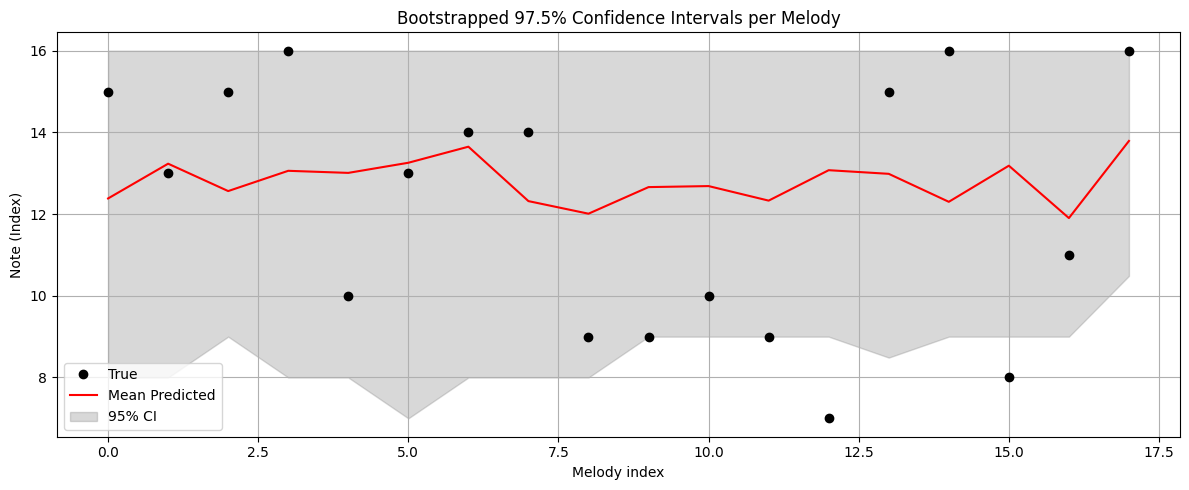

In [14]:
X, y, (min_midi, max_midi) = get_onehot_midi_sequences("data/truncated_stems.csv", feature_steps=range(1,7), target_col='step7')
sequence_len = X.shape[1]
num_pitches = X.shape[2]
output_dim = num_pitches

X_train, X_test, y_train, y_test = train_test_split(
    torch.tensor(X), 
    torch.tensor(y), 
    test_size=0.2, 
    random_state=42
)

model_class = OneHotMLP
model_kwargs = {
    "sequence_len": sequence_len,
    "num_pitches": num_pitches,
    "output_dim": output_dim
}

criterion = nn.CrossEntropyLoss()

results = evaluate_NN_model(
    model_class=model_class,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_bootstrap=1000,
    alpha=0.025,
    train_fn=simple_train_fn,
    criterion=criterion,
    model_kwargs=model_kwargs
)

## PolyMLP with Raw Flattened Input


Bootstrapped Prediction Evaluation (1000 models)
97.5% CI coverage: 88.89%
MSE: 8.98
R²: -0.0036

Melody 1: Mean Pred = 12.3, CI = [8.0, 16.0], True = 15 → Pass
Melody 2: Mean Pred = 13.2, CI = [8.0, 16.0], True = 13 → Pass
Melody 3: Mean Pred = 12.5, CI = [8.0, 16.0], True = 15 → Pass
Melody 4: Mean Pred = 13.1, CI = [8.0, 16.0], True = 16 → Pass
Melody 5: Mean Pred = 13.1, CI = [8.0, 16.0], True = 10 → Pass
Melody 6: Mean Pred = 13.2, CI = [7.0, 16.0], True = 13 → Pass
Melody 7: Mean Pred = 13.5, CI = [8.0, 16.0], True = 14 → Pass
Melody 8: Mean Pred = 12.2, CI = [8.0, 16.0], True = 14 → Pass
Melody 9: Mean Pred = 11.9, CI = [8.0, 16.0], True = 9 → Pass
Melody 10: Mean Pred = 12.7, CI = [8.0, 16.0], True = 9 → Pass
Melody 11: Mean Pred = 12.6, CI = [8.5, 16.0], True = 10 → Pass
Melody 12: Mean Pred = 12.3, CI = [9.0, 16.0], True = 9 → Pass
Melody 13: Mean Pred = 13.1, CI = [9.0, 16.0], True = 7 → Fail
Melody 14: Mean Pred = 13.0, CI = [8.0, 16.0], True = 15 → Pass
Melody 15: Mean Pr

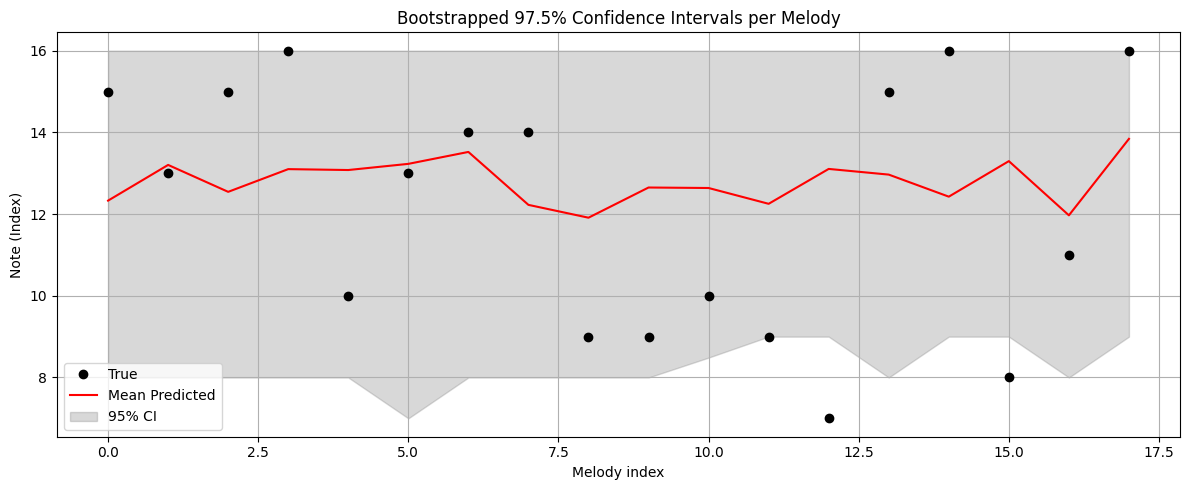

In [15]:
# --- Load and flatten one-hot input ---
X, y, _ = get_onehot_midi_sequences("data/truncated_stems.csv", feature_steps=range(1, 7), target_col='step7')
X_flat = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(
    torch.tensor(X_flat, dtype=torch.float32), 
    torch.tensor(y, dtype=torch.long), 
    test_size=0.2, 
    random_state=42
)

model_class = PolyMLP
model_kwargs = {
    "input_dim": X_flat.shape[1],
    "hidden_dim": 128,
    "output_dim": 88
}

criterion = nn.CrossEntropyLoss()

results = evaluate_NN_model(
    model_class=model_class,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_bootstrap=1000,
    alpha=0.025,
    train_fn=simple_train_fn,
    criterion=criterion,
    model_kwargs=model_kwargs
)

## Polynomial Expansion + PolyMLP


Bootstrapped Prediction Evaluation (1000 models)
97.5% CI coverage: 72.22%
MSE: 9.05
R²: -0.0112

Melody 1: Mean Pred = 12.1, CI = [8.0, 16.0], True = 15 → Pass
Melody 2: Mean Pred = 13.5, CI = [9.0, 16.0], True = 13 → Pass
Melody 3: Mean Pred = 11.9, CI = [11.0, 16.0], True = 15 → Pass
Melody 4: Mean Pred = 13.6, CI = [8.0, 16.0], True = 16 → Pass
Melody 5: Mean Pred = 13.4, CI = [11.0, 16.0], True = 10 → Fail
Melody 6: Mean Pred = 14.1, CI = [7.0, 16.0], True = 13 → Pass
Melody 7: Mean Pred = 14.2, CI = [9.0, 16.0], True = 14 → Pass
Melody 8: Mean Pred = 12.0, CI = [8.0, 15.0], True = 14 → Pass
Melody 9: Mean Pred = 11.0, CI = [8.0, 15.5], True = 9 → Pass
Melody 10: Mean Pred = 12.3, CI = [10.0, 14.0], True = 9 → Fail
Melody 11: Mean Pred = 12.3, CI = [9.0, 16.0], True = 10 → Pass
Melody 12: Mean Pred = 11.6, CI = [9.0, 16.0], True = 9 → Pass
Melody 13: Mean Pred = 13.6, CI = [9.0, 16.0], True = 7 → Fail
Melody 14: Mean Pred = 13.6, CI = [11.0, 16.0], True = 15 → Pass
Melody 15: Mea

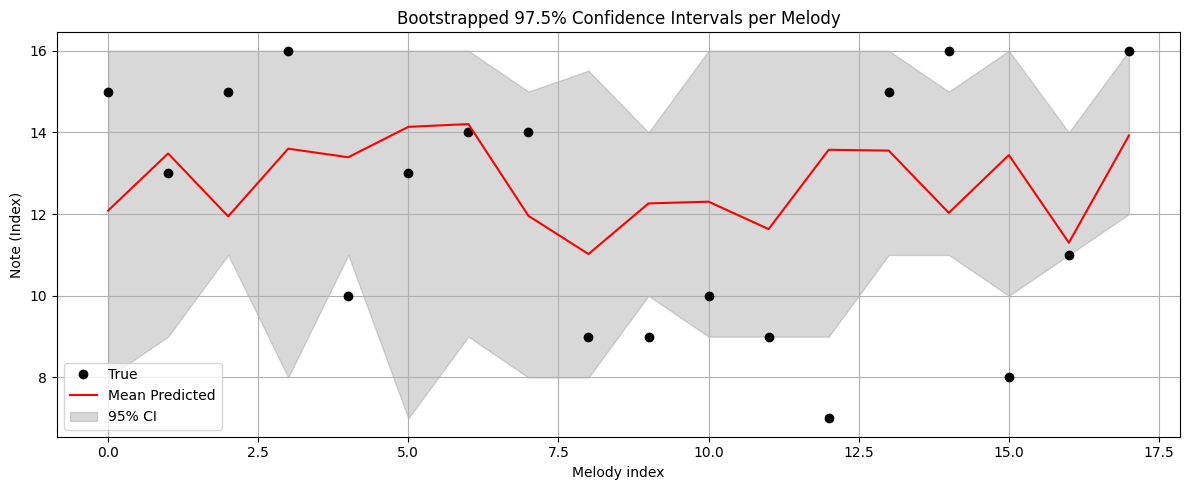

In [16]:
# --- Load and preprocess data ---
X, y, _ = get_onehot_midi_sequences("data/truncated_stems.csv", feature_steps=range(1, 7), target_col='step7')
X_poly = apply_polynomial_expansion(X, degree=2)

X_train, X_test, y_train, y_test = train_test_split(
    torch.tensor(X_poly, dtype=torch.float32), 
    torch.tensor(y, dtype=torch.long), 
    test_size=0.2, 
    random_state=42
)

model_class = PolyMLP
model_kwargs = {
    "input_dim": X_poly.shape[1],
    "hidden_dim": 128,
    "output_dim": 88
}

criterion = nn.CrossEntropyLoss()

results = evaluate_NN_model(
    model_class=model_class,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_bootstrap=1000,
    alpha=0.025,
    train_fn=simple_train_fn,
    criterion=criterion,
    model_kwargs=model_kwargs
)

## RBF Kernel + PolyMLP


Bootstrapped Prediction Evaluation (1000 models)
97.5% CI coverage: 83.33%
MSE: 9.30
R²: -0.0385

Melody 1: Mean Pred = 12.7, CI = [9.0, 16.0], True = 15 → Pass
Melody 2: Mean Pred = 13.2, CI = [9.0, 16.0], True = 13 → Pass
Melody 3: Mean Pred = 13.0, CI = [9.0, 16.0], True = 15 → Pass
Melody 4: Mean Pred = 13.0, CI = [9.0, 16.0], True = 16 → Pass
Melody 5: Mean Pred = 12.9, CI = [9.0, 16.0], True = 10 → Pass
Melody 6: Mean Pred = 13.1, CI = [9.0, 16.0], True = 13 → Pass
Melody 7: Mean Pred = 13.2, CI = [9.0, 16.0], True = 14 → Pass
Melody 8: Mean Pred = 12.8, CI = [9.0, 16.0], True = 14 → Pass
Melody 9: Mean Pred = 12.8, CI = [8.0, 16.0], True = 9 → Pass
Melody 10: Mean Pred = 13.0, CI = [9.5, 16.0], True = 9 → Fail
Melody 11: Mean Pred = 12.8, CI = [9.0, 16.0], True = 10 → Pass
Melody 12: Mean Pred = 12.6, CI = [9.0, 16.0], True = 9 → Pass
Melody 13: Mean Pred = 12.8, CI = [9.0, 16.0], True = 7 → Fail
Melody 14: Mean Pred = 13.0, CI = [9.0, 16.0], True = 15 → Pass
Melody 15: Mean Pr

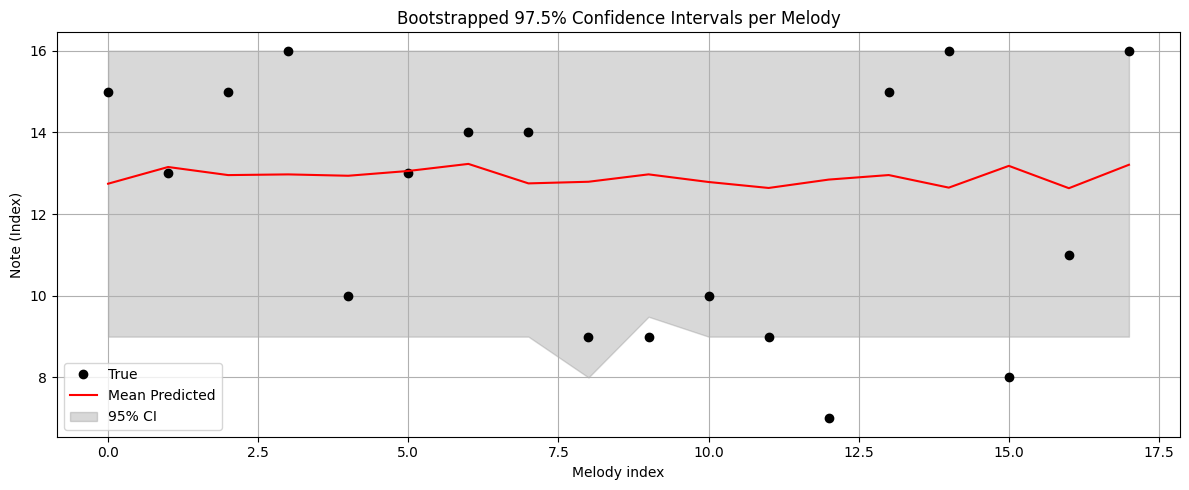

In [17]:
# --- Load and preprocess data ---
X, y, _ = get_onehot_midi_sequences("data/truncated_stems.csv", feature_steps=range(1, 7), target_col='step7')
X_rbf = apply_rbf_kernel_approximation(X, gamma=0.1, n_components=500)

X_train, X_test, y_train, y_test = train_test_split(
    torch.tensor(X_rbf, dtype=torch.float32), 
    torch.tensor(y, dtype=torch.long), 
    test_size=0.2, 
    random_state=42
)

model_class = PolyMLP
model_kwargs = {
    "input_dim": X_rbf.shape[1],
    "hidden_dim": 128,
    "output_dim": 88
}

criterion = nn.CrossEntropyLoss()

results = evaluate_NN_model(
    model_class=model_class,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_bootstrap=1000,
    alpha=0.025,
    train_fn=simple_train_fn,
    criterion=criterion,
    model_kwargs=model_kwargs
)

## DeepMLP with Raw One-Hot Input


Bootstrapped Prediction Evaluation (1000 models)
97.5% CI coverage: 88.89%
MSE: 9.23
R²: -0.0316

Melody 1: Mean Pred = 12.8, CI = [9.0, 16.0], True = 15 → Pass
Melody 2: Mean Pred = 13.0, CI = [9.0, 16.0], True = 13 → Pass
Melody 3: Mean Pred = 12.8, CI = [9.0, 16.0], True = 15 → Pass
Melody 4: Mean Pred = 12.9, CI = [9.0, 16.0], True = 16 → Pass
Melody 5: Mean Pred = 12.9, CI = [9.0, 16.0], True = 10 → Pass
Melody 6: Mean Pred = 12.9, CI = [9.0, 16.0], True = 13 → Pass
Melody 7: Mean Pred = 13.1, CI = [9.0, 16.0], True = 14 → Pass
Melody 8: Mean Pred = 12.8, CI = [9.0, 16.0], True = 14 → Pass
Melody 9: Mean Pred = 12.7, CI = [8.5, 16.0], True = 9 → Pass
Melody 10: Mean Pred = 12.9, CI = [9.0, 16.0], True = 9 → Pass
Melody 11: Mean Pred = 12.8, CI = [9.0, 16.0], True = 10 → Pass
Melody 12: Mean Pred = 12.8, CI = [9.0, 16.0], True = 9 → Pass
Melody 13: Mean Pred = 12.9, CI = [9.0, 16.0], True = 7 → Fail
Melody 14: Mean Pred = 12.9, CI = [9.0, 16.0], True = 15 → Pass
Melody 15: Mean Pr

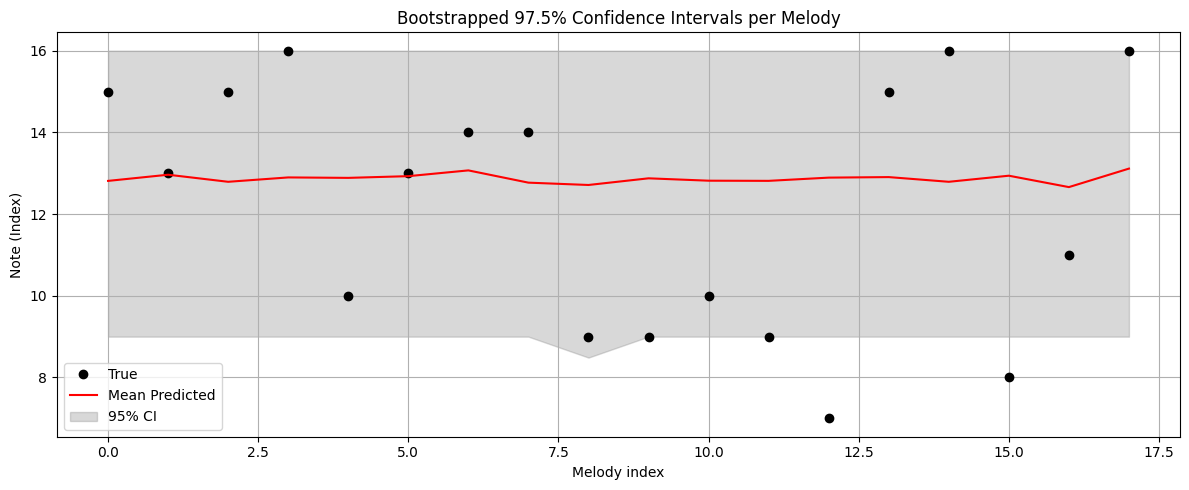

In [18]:
# --- Load one-hot input as 3D tensors ---
X, y, (min_midi, max_midi) = get_onehot_midi_sequences("data/truncated_stems.csv", feature_steps=range(1, 7), target_col='step7')
sequence_len = X.shape[1]
num_pitches = X.shape[2]
output_dim = num_pitches

X_train, X_test, y_train, y_test = train_test_split(
    torch.tensor(X, dtype=torch.float32), 
    torch.tensor(y, dtype=torch.long), 
    test_size=0.2, 
    random_state=42
)

model_class = DeepMLP
model_kwargs = {
    "sequence_len": sequence_len,
    "num_pitches": num_pitches,
    "hidden_dims": [256, 128, 64],
    "output_dim": output_dim
}

criterion = nn.CrossEntropyLoss()

results = evaluate_NN_model(
    model_class=model_class,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_bootstrap=1000,
    alpha=0.025,
    train_fn=simple_train_fn,
    criterion=criterion,
    model_kwargs=model_kwargs
)